In [2]:
import cv2
import keras
import keras.backend as K
from keras.backend.tensorflow_backend import set_session
from keras.callbacks import Callback
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time
import glob
import pickle

from sl_model import SL512, DSODSL512
from ssd_data import InputGenerator
from ssd_data import preprocess
from sl_utils import PriorUtil
from ssd_utils import load_weights, calc_memory_usage
from ssd_training import Logger, LearningRateDecay
from sl_training import SegLinkLoss, SegLinkFocalLoss

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True, linewidth=120)

In [2]:
from data_synthtext import GTUtility

file_name = 'gt_util_synthtext_seglink.pkl'
with open(file_name, 'rb') as f:
    gt_util = pickle.load(f)
gt_util_train, gt_util_val = gt_util.split(gt_util, split=0.95)

print(gt_util)

Background              0
Text              7266338

images             858749
objects           7266338
per image            8.46
no annotation           0



In [3]:
gt_util_synth, foo = gt_util.split(gt_util, split=0.005)
print(gt_util_synth)

Background              0
Text                42095

images               4294
objects             42095
per image            9.80
no annotation           0



In [4]:
from data_icdar2015fst import GTUtility
gt_util_icdar = GTUtility('data/ICDAR2015_FST/', test=False, polygon=True)
print(gt_util_icdar)

Background              0
Text                  849

images                229
objects               849
per image            3.71
no annotation           0



In [5]:
gt_util_train = GTUtility.merge(gt_util_synth, gt_util_icdar)
print(gt_util_train)

Background              0
Text                42944

images               4523
objects             42944
per image            9.49
no annotation           0



In [6]:
#model = SL512()
model = DSODSL512()
#model = DSODSL512(activation='leaky_relu')
prior_util = PriorUtil(model, model.source_layers_names)
image_size = model.image_size
calc_memory_usage(model) # calc_model_size

model memory usage 1.50 GB


In [7]:
inputs = []
images = []
data = []

gtu = gt_util_val

np.random.seed(1337)

for i in np.random.randint(0, gtu.num_samples, 16):

    img_path = os.path.join(gtu.image_path, gtu.image_names[i])
    img = cv2.imread(img_path)
    
    inputs.append(preprocess(img, image_size))
    
    h, w = image_size
    img = cv2.resize(img, (w,h), cv2.INTER_LINEAR).astype('float32') # should we do resizing
    img = img[:, :, (2,1,0)] # BGR to RGB
    img /= 255
    images.append(img)
    
    boxes = gtu.data[i]
    data.append(boxes)

inputs = np.asarray(inputs)

test_idx = 0
test_input = inputs[test_idx]
test_img = images[test_idx]
test_gt = data[test_idx]

#plt.figure()
#plt.imshow(test_img)
#gt_util.plot_gt(test_gt, show_labels=False)
#plt.show()

In [8]:
weights_path = '~/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
layer_list = ['conv1_1', 'conv1_2',
              'conv2_1', 'conv2_2',
              'conv3_1', 'conv3_2', 'conv3_3',
              'conv4_1', 'conv4_2', 'conv4_3',
              'conv5_1', 'conv5_2', 'conv5_3',
              'fc6', 'fc7',
              'conv6_1', 'conv6_2',
              'conv7_1', 'conv7_2',
              'conv8_1', 'conv8_2',
              'conv9_1', 'conv9_2',
              ]
#load_weights(model, weights_path, layer_list)

#weights_path = 'ssd512_voc_weights_fixed.hdf5'
#weights_path = './checkpoints/201710242216_sl512_synthtext/weights.003.h5'
#weights_path = './checkpoints/201711071436_sl512_synthtext/weights.001.h5'
#load_weights(model, weights_path)

freeze = ['conv1_1', 'conv1_2',
          'conv2_1', 'conv2_2',
          'conv3_1', 'conv3_2', 'conv3_3',
          #'conv4_1', 'conv4_2', 'conv4_3',
          #'conv5_1', 'conv5_2', 'conv5_3',
         ]
freeze = []

### Training

In [9]:
from data_icdar2015fst import GTUtility
#gt_util = GTUtility('data/ICDAR2015_FST/')
gt_util_test = GTUtility('data/ICDAR2015_FST/', test=True, polygon=True)

In [ ]:
batch_size = 6

gen = InputGenerator(gt_util_train, gt_util_test, prior_util, 
        batch_size, image_size, 
        saturation_var=0.5,
        brightness_var=0.5,
        contrast_var=0.5,
        lighting_std=0.5,
        hflip_prob=0.0,
        vflip_prob=0.0,
        do_crop=True,
        add_noise=True,
        crop_area_range=[0.9, 1.0],
        aspect_ratio_range=[2/3, 5/3])

In [ ]:
#epochs = 6
#epochs = 40
epochs = 1100
initial_epoch = 0
#initial_epoch = 6
#batch_size = 24
#batch_size = 6

#experiment = 'sl512_synthtext'
#experiment = 'dsodsl512_synthtext'
#experiment = 'sl_synthtext_ssd_sgd'
experiment = 'sl_synthtext_dsod_adam_focal'
experiment = 'sl_icdar+0.005synthtext_dsod_adam_focal_icdar'
experiment = 'sl_icdar+0.005synthtext_dsod_adam_focal_icdar_leaky_noweightdecay'
experiment = 'sl_icdar+0.005synthtext_dsod_adam_focal_icdar_leaky'
experiment = 'sl_icdar+0.005synthtext_dsod_adam_focal_icdar_augmentedval'
experiment = 'sl_icdar+0.005synthtext_dsod_adam_focal_icdar_inputscale_0_10'
experiment = 'sl_icdar+0.005synthtext_dsod_adam_focal_icdar_lambda_1_1_1'
experiment = 'sl_icdar+0.005synthtext_dsod_adam_focal_icdar_gamma_3_3'
experiment = 'sl_icdar+0.005synthtext_dsod_adam_focal_icdar_gamma_1.5_1.5'
experiment = 'sl_icdar+0.005synthtext_dsod_adam_focal_icdar_gamma_2_2.25'

#gen = InputGenerator(gt_util_train, gt_util_val, prior_util, batch_size, image_size)

for layer in model.layers:
    layer.trainable = not layer.name in freeze

checkdir = './checkpoints/' + time.strftime('%Y%m%d%H%M') + '_' + experiment
if not os.path.exists(checkdir):
    os.makedirs(checkdir)

with open(checkdir+'/source.py','wb') as f:
    source = ''.join(['# In[%i]\n%s\n\n' % (i, In[i]) for i in range(len(In))])
    f.write(source.encode())

optim = keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=0.001, decay=0.0)
#optim = keras.optimizers.SGD(lr=1e-3, momentum=0.9, decay=0, nesterov=True)

# weight decay
regularizer = keras.regularizers.l2(5e-4) # None if disabled
#regularizer = None
for l in model.layers:
    if l.__class__.__name__.startswith('Conv'):
        l.kernel_regularizer = regularizer

#loss = SegLinkLoss(lambda_offsets=1.0, lambda_links=1.0, neg_pos_ratio=3.0)
#loss = SegLinkFocalLoss()
#loss = SegLinkFocalLoss(lambda_segments=1.0, lambda_offsets=1.0, lambda_links=1.0)
#loss = SegLinkFocalLoss(gamma_segments=3, gamma_links=3)
#loss = SegLinkFocalLoss(gamma_segments=1.5, gamma_links=1.5)
loss = SegLinkFocalLoss(gamma_segments=2, gamma_links=2.25)

model.compile(optimizer=optim,
              loss=loss.compute,
              metrics=loss.metrics)

callbacks = [keras.callbacks.ModelCheckpoint(checkdir+'/weights.{epoch:03d}.h5',
                                             verbose=1, save_weights_only=True),
             Logger(checkdir),
             #LearningRateDecay()
            ]

history = model.fit_generator(
        #gen.generate(train=True, augmentation=False), #generator, 
        gen.generate(train=True, augmentation=True), #generator, 
        gen.num_train_batches, 
        epochs=epochs, 
        verbose=1, 
        callbacks=callbacks, 
        validation_data=gen.generate(train=False, augmentation=False), 
        validation_steps=gen.num_val_batches, 
        class_weight=None,
        max_queue_size=1, 
        workers=1, 
        #use_multiprocessing=False, 
        initial_epoch=initial_epoch, 
        #pickle_safe=False, # will use threading instead of multiprocessing, which is lighter on memory use but slower
        )

Epoch 1/1100
752/753 [============================>.] - ETA: 0s - loss: 5.8952 - seg_conf_loss: 2.1174 - seg_loc_loss: 3.2909 - link_conf_loss: 0.4869 - seg_precision: 0.2617 - seg_recall: 0.0326 - seg_accuracy: 0.0300 - seg_fmeasure: 0.0508 - link_precision: 0.0252 - link_recall: 0.0013 - link_accuracy: 9.9734e-04 - link_fmeasure: 0.0019
new epoch, train True

new epoch, train False
Epoch 00001: saving model to ./checkpoints/201802170916_sl_icdar+0.005synthtext_dsod_adam_focal_icdar_gamma_2_2.25/weights.001.h5
753/753 [==============================] - 511s 679ms/step - loss: 5.8916 - seg_conf_loss: 2.1156 - seg_loc_loss: 3.2897 - link_conf_loss: 0.4863 - seg_precision: 0.2626 - seg_recall: 0.0330 - seg_accuracy: 0.0303 - seg_fmeasure: 0.0513 - link_precision: 0.0252 - link_recall: 0.0013 - link_accuracy: 9.9602e-04 - link_fmeasure: 0.0019 - val_loss: 6.7994 - val_seg_conf_loss: 1.8967 - val_seg_loc_loss: 4.5940 - val_link_conf_loss: 0.3087 - val_seg_precision: 0.1342 - val_seg_recall

### Predictions

In [ ]:
#weights_path = './checkpoints/201801051327_sl_synthtext_ssd_sgd/weights.004.h5'
#weights_path = './checkpoints/201801101147_sl_synthtext_dsod_adam_focal/weights.002.h5'
#weights_path = './checkpoints/201801121425_sl_synthtext_dsod_adam_focal/weights.004.h5'
weights_path = './checkpoints/201801142030_sl_synthtext_dsod_adam_focal/weights.006.h5'
load_weights(model, weights_path)
checkdir = os.path.split(weights_path)[0]

In [ ]:
inputs = []
images = []
data = []

gtu = gt_util_train
gtu = gt_util_val
gtu = gt_util_test

np.random.seed(1337)

for i in np.random.randint(0, gtu.num_samples, 16):

    img_path = os.path.join(gtu.image_path, gtu.image_names[i])
    img = cv2.imread(img_path)
    
    inputs.append(preprocess(img, image_size))
    
    h, w = image_size
    img = cv2.resize(img, (w,h), cv2.INTER_LINEAR).astype('float32')
    img = img[:, :, (2,1,0)] # BGR to RGB
    img /= 255
    images.append(img)
    
    boxes = gtu.data[i]
    data.append(boxes)
    
inputs = np.asarray(inputs)

preds = model.predict(inputs, batch_size=1, verbose=1)

In [ ]:
for fl in glob.glob('%s/result_*' % (checkdir,)):
    #os.remove(fl)
    pass

for i in range(len(preds)):
    plt.figure()#figsize=[20]*2)
    plt.imshow(images[i])
    #res = prior_util.decode(preds[i], segment_threshold=0.55, link_threshold=0.35, debug=False)
    #res = prior_util.decode(preds[i], segment_threshold=0.6, link_threshold=0.45, debug=False) # with DSOD body
    res = prior_util.decode(preds[i], segment_threshold=0.6, link_threshold=0.4, debug=False) # with DSOD body
    #res = prior_util.decode(preds[i], segment_threshold=0.75, link_threshold=0.5, debug=False) # with SSD body
    prior_util.encode(data[i])
    prior_util.plot_gt()
    prior_util.plot_results(res)
    #plt.savefig('%s/result_%03d.jpg' % (checkdir, i))
    plt.show()

In [ ]:
for i in range(len(preds)):
    plt.figure(figsize=[20]*2)
    plt.imshow(images[i])
    encgt = prior_util.encode(data[i])
    prior_util.plot_gt()
    prior_util.plot_local_evaluation(encgt, preds[i], segment_threshold=0.6, link_threshold=0.45)
    plt.show()

In [ ]:
for i in range(2): #range(len(preds)):
    plt.figure()
    plt.imshow(images[i])
    res = prior_util.decode(preds[i], segment_threshold=0.6, link_threshold=0.45, debug=False)
    prior_util.encode(data[i])
    prior_util.plot_gt()
    for j in range(prior_util.num_maps):
        prior_util.plot_assignement(j)
    prior_util.plot_results(res)
    plt.show()

### grid search, copy from SL_evaluate

In [ ]:
from data_icdar2015ist import GTUtility
gt_util_test = GTUtility('data/ICDAR2015_IST/', test=True)

In [ ]:
from data_icdar2015fst import GTUtility
#gt_util = GTUtility('data/ICDAR2015_FST/')
gt_util_test = GTUtility('data/ICDAR2015_FST/', test=True, polygon=True)

In [12]:
inputs = []
images = []
data = []

gtu = gt_util_train
gtu = gt_util_val
gtu = gt_util_test

np.random.seed(1337)

#for i in np.random.randint(0, gtu.num_samples, 512):
for i in range(gtu.num_samples):

    img_path = os.path.join(gtu.image_path, gtu.image_names[i])
    img = cv2.imread(img_path)
    
    inputs.append(preprocess(img, image_size))
    
    h, w = image_size
    img = cv2.resize(img, (w,h), cv2.INTER_LINEAR).astype('float32') # should we do resizing
    img = img[:, :, (2,1,0)] # BGR to RGB
    img /= 255
    images.append(img)
    
    boxes = gtu.data[i]
    data.append(boxes)
    
inputs = np.asarray(inputs)

preds = model.predict(inputs, batch_size=1, verbose=1)

233/233 [==============================] - 12s 52ms/step


In [13]:
from sl_metric import evaluate_results, fscore

steps_seg = np.arange(0.1, 1, 0.1)
steps_lnk = np.arange(0.1, 1, 0.1)

#steps_seg = np.arange(0.5, 0.7, 0.02)
#steps_lnk = np.arange(0.3, 0.6, 0.02)
# --> segment_threshold 0.59 link_threshold 0.47

fmes_grid = np.zeros((len(steps_seg),len(steps_lnk)))

for i, segment_threshold in enumerate(steps_seg):
    for j, link_threshold in enumerate(steps_lnk):
        results = [prior_util.decode(p, segment_threshold=segment_threshold, link_threshold=link_threshold) for p in preds]
        TP, FP, FN = evaluate_results(data, results)
        recall = TP / (TP+FN)
        precision = TP / (TP+FP)
        fmes = fscore(precision, recall)
        fmes_grid[i,j] = fmes
        print('segment_threshold %.2f link_threshold %.2f f-measure %.2f' % (segment_threshold, link_threshold, fmes))
        
print(fmes_grid)
print(np.max(fmes_grid))

segment_threshold 0.10 link_threshold 0.10 f-measure 0.21
segment_threshold 0.10 link_threshold 0.20 f-measure 0.12
segment_threshold 0.10 link_threshold 0.30 f-measure 0.09
segment_threshold 0.10 link_threshold 0.40 f-measure 0.08
segment_threshold 0.10 link_threshold 0.50 f-measure 0.07
segment_threshold 0.10 link_threshold 0.60 f-measure 0.06
segment_threshold 0.10 link_threshold 0.70 f-measure 0.06
segment_threshold 0.10 link_threshold 0.80 f-measure 0.05
segment_threshold 0.10 link_threshold 0.90 f-measure 0.03
segment_threshold 0.20 link_threshold 0.10 f-measure 0.37
segment_threshold 0.20 link_threshold 0.20 f-measure 0.42
segment_threshold 0.20 link_threshold 0.30 f-measure 0.27
segment_threshold 0.20 link_threshold 0.40 f-measure 0.18
segment_threshold 0.20 link_threshold 0.50 f-measure 0.14
segment_threshold 0.20 link_threshold 0.60 f-measure 0.12
segment_threshold 0.20 link_threshold 0.70 f-measure 0.10
segment_threshold 0.20 link_threshold 0.80 f-measure 0.08
segment_thresh

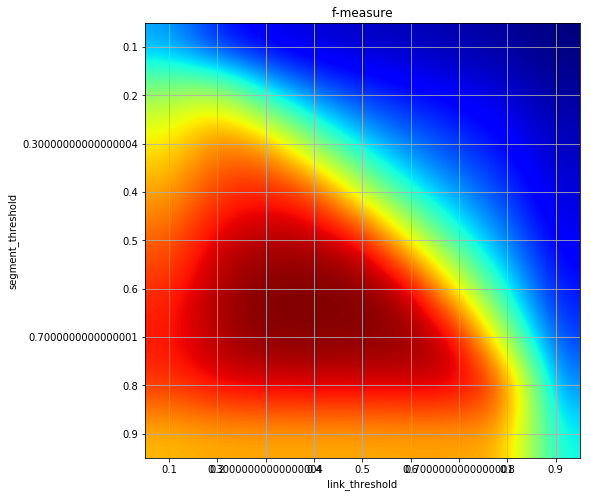

In [14]:
plt.imshow(fmes_grid, cmap='jet', interpolation='bicubic')# nearest, bicubic
plt.title('f-measure')
plt.xticks(range(len(steps_lnk)), steps_lnk)
plt.yticks(range(len(steps_seg)), steps_seg)
plt.xlabel('link_threshold')
plt.ylabel('segment_threshold')
plt.grid()
plt.show()

In [ ]:

class InputGenerator(object):
    # flag to protect bounding boxes from cropping?
    def __init__(self, 
                gt_util_train, gt_util_val, prior_util,
                batch_size, input_size,
                saturation_var=0.5,
                brightness_var=0.5,
                contrast_var=0.5,
                lighting_std=0.5,
                hflip_prob=0.5,
                vflip_prob=0.0,
                do_crop=True,
                add_noise=True,
                crop_area_range=[0.75, 1.0],
                aspect_ratio_range=[4./3., 3./4.]):
        
        self.prior_util = prior_util
        self.batch_size = batch_size
        self.input_size = input_size
        
        self.gt_util_train = gt_util_train
        self.num_train_batches = gt_util_train.num_samples // batch_size
        
        self.gt_util_val = gt_util_val
        self.num_val_batches = gt_util_val.num_samples // batch_size
        
        self.color_jitter = []
        if saturation_var:
            self.saturation_var = saturation_var
            self.color_jitter.append(self.saturation)
        if brightness_var:
            self.brightness_var = brightness_var
            self.color_jitter.append(self.brightness)
        if contrast_var:
            self.contrast_var = contrast_var
            self.color_jitter.append(self.contrast)
        self.lighting_std = lighting_std
        self.hflip_prob = hflip_prob
        self.vflip_prob = vflip_prob
        self.do_crop = do_crop
        self.add_noise = add_noise
        self.crop_area_range = crop_area_range
        self.aspect_ratio_range = aspect_ratio_range
    
    def __str__(self):
        f = '%-20s %s\n'
        s = ''
        s += f % ('input_size', self.input_size)
        s += f % ('batch_size', self.num_batch_size)
        s += f % ('num_train_samples', self.gt_util_train.num_samples)
        s += f % ('num_train_batches', self.num_train_batches)
        s += f % ('num_val_samples', self.gt_util_val.num_samples)
        s += f % ('num_val_batches', self.val_batches)
        return s
    
    def grayscale(self, rgb):
        return rgb.dot([0.299, 0.587, 0.114])

    def saturation(self, rgb):
        gs = self.grayscale(rgb)
        alpha = 2 * np.random.random() * self.saturation_var 
        alpha += 1 - self.saturation_var
        rgb = rgb * alpha + (1 - alpha) * gs[:, :, None]
        return np.clip(rgb, 0, 255)

    def brightness(self, rgb):
        alpha = 2 * np.random.random() * self.brightness_var 
        alpha += 1 - self.saturation_var
        rgb = rgb * alpha
        return np.clip(rgb, 0, 255)

    def contrast(self, rgb):
        gs = self.grayscale(rgb).mean() * np.ones_like(rgb)
        alpha = 2 * np.random.random() * self.contrast_var 
        alpha += 1 - self.contrast_var
        rgb = rgb * alpha + (1 - alpha) * gs
        return np.clip(rgb, 0, 255)

    def lighting(self, img):
        cov = np.cov(img.reshape(-1, 3) / 255.0, rowvar=False)
        eigval, eigvec = np.linalg.eigh(cov)
        noise = np.random.randn(3) * self.lighting_std
        noise = eigvec.dot(eigval * noise) * 255
        img += noise
        return np.clip(img, 0, 255)
    
    def noise(self, img):
        img_size = img.shape[:2]
        scale = np.random.randint(16)
        noise = np.array(np.random.exponential(scale, img_size), dtype=np.int) * np.random.randint(-1,2, size=img_size)
        #noise = np.array(np.random.normal(0, scale, img_size), dtype=np.int)
        noise = np.repeat(noise[:, :, np.newaxis], 3, axis=2)
        img = img + noise
        return np.clip(img, 0, 255)
    
    def horizontal_flip(self, img, y):
        if np.random.random() < self.hflip_prob:
            img = img[:, ::-1]
            num_coords = y.shape[1] - self.gt_util_train.num_classes
            if num_coords == 8: # polygon case
                y[:, [0, 2, 4, 6]] = 1 - y[:, [2, 0, 6, 4]]
                y[:, [1, 3, 5, 7]] = y[:, [3, 1, 7, 5]]
            else:
                y[:, [0, 2]] = 1 - y[:, [2, 0]]    
        return img, y
    
    def vertical_flip(self, img, y):
        if np.random.random() < self.vflip_prob:
            img = img[::-1]
            if num_coords == 8: # polynom case
                y[:, [0, 2, 4, 6]] = y[:, [6, 4, 2, 0]]
                y[:, [1, 3, 5, 7]] = 1 - y[:, [7, 5, 3, 1]]
            else:
                y[:, [1, 3]] = 1 - y[:, [3, 1]]
        return img, y
    
    def random_sized_crop(self, img, target):
        img_h, img_w = img.shape[:2]
        
        # make sure that we can preserve the aspect ratio
        ratio_range = self.aspect_ratio_range
        random_ratio = ratio_range[0] + np.random.random() * (ratio_range[1] - ratio_range[0])
        # a = w/h, w_i-w >= 0, h_i-h >= 0 leads to LP: max. h s.t. h <= w_i/a, h <= h_i
        max_h = min(img_w/random_ratio, img_h)
        max_w = max_h * random_ratio
        
        # scale the area
        crop_range = self.crop_area_range
        random_scale = crop_range[0] + np.random.random() * (crop_range[1] - crop_range[0])
        target_area = random_scale * max_w * max_h
        w = np.round(np.sqrt(target_area * random_ratio))
        h = np.round(np.sqrt(target_area / random_ratio))
        
        x = np.random.random() * (img_w - w)
        y = np.random.random() * (img_h - h)
        
        w_rel = w / img_w
        h_rel = h / img_h
        x_rel = x / img_w
        y_rel = y / img_h
        
        w = int(w)
        h = int(h)
        x = int(x)
        y = int(y)
        
        # crop image and transform boxes
        new_img = img[y:y+h, x:x+w]
        new_target = []
        num_coords = target.shape[1] - self.gt_util_train.num_classes
        new_target = []
        if num_coords == 8: # polynom case
            for box in target:
                new_box = np.copy(box)
                new_box[0:8:2] -= x_rel
                new_box[0:8:2] /= w_rel
                new_box[1:8:2] -= y_rel
                new_box[1:8:2] /= h_rel
                
                if (new_box[0] < 1 and new_box[6] < 1 and new_box[2] > 0 and new_box[4] > 0 and 
                    new_box[1] < 1 and new_box[3] < 1 and new_box[5] > 0 and new_box[7] > 0):
                    new_target.append(new_box)
            new_target = np.asarray(new_target)
        else:
            for box in target:
                xmin = (box[0] - x_rel) / w_rel
                ymin = (box[1] - y_rel) / h_rel
                xmax = (box[2] - x_rel) / w_rel
                ymax = (box[3] - y_rel) / h_rel
                box_w = xmax - xmin
                box_h = ymax - ymin

                # add only boxes if width and height is larger then 10% of original width and height
                a = 0.1
                if (xmax-0 > a*box_w and 1-xmin > a*box_w and
                    ymax-0 > a*box_h and 1-ymin > a*box_h):
                    new_box = np.copy(box)
                    new_box[:4] = np.clip([xmin, ymin, xmax, ymax], 0, 1)
                    new_target.append(new_box)
            new_target = np.asarray(new_target).reshape(-1, target.shape[1])
        return new_img, new_target
    
    def generate(self, train=True, augmentation=False, debug=False):
        h, w = self.input_size
        batch_size = self.batch_size
        mean = np.array([104,117,123])
        if train:
            gt_util = self.gt_util_train
            num_batches = self.num_train_batches
        else:
            gt_util = self.gt_util_val
            num_batches = self.num_val_batches
        
        inputs = []
        targets = []
        
        while True:
            idxs = np.arange(gt_util.num_samples)
            np.random.shuffle(idxs)
            idxs = idxs[:num_batches*batch_size]
            for j, i in enumerate(idxs):
                img_name = gt_util.image_names[i]
                img_path = os.path.join(gt_util.image_path, img_name)
                img = cv2.imread(img_path)
                y = np.copy(gt_util.data[i])
                
                if debug:
                    raw_img = img.astype(np.float32)
                    raw_y = np.copy(y)
                
                if augmentation:
                    if self.do_crop:
                        for _ in range(10): # tries to crop without losing ground truth
                            img_tmp, y_tmp = self.random_sized_crop(img, y)
                            if len(y_tmp) > 0:
                                break
                        if len(y_tmp) > 0:
                            img = img_tmp
                            y = y_tmp
                        
                    img = cv2.resize(img, (w,h), cv2.INTER_LINEAR)
                    img = img.astype(np.float32)
                    
                    random.shuffle(self.color_jitter)
                    for jitter in self.color_jitter:
                        img = jitter(img)
                    if self.lighting_std:
                        img = self.lighting(img)
                    if self.hflip_prob > 0:
                        img, y = self.horizontal_flip(img, y)
                    if self.vflip_prob > 0:
                        img, y = self.vertical_flip(img, y)
                    if self.add_noise:
                        img = self.noise(img)
                else:
                    img = cv2.resize(img, (w,h), cv2.INTER_LINEAR)
                    img = img.astype(np.float32)
                
                if debug:
                    # origal gt image
                    plt.figure()
                    dbg_img = np.copy(raw_img)
                    dbg_img /= 256
                    dbg_img = dbg_img[:,:,(2,1,0)]
                    plt.imshow(dbg_img)
                    gt_util.plot_gt(raw_y)
                    plt.show()
                    # network input image
                    plt.figure()
                    dbg_img = np.copy(img)
                    dbg_img /= 256
                    dbg_img = dbg_img[:,:,(2,1,0)]
                    plt.imshow(dbg_img)
                    gt_util.plot_gt(y)
                    plt.show()
                    
                img -= mean[np.newaxis, np.newaxis, :]
                y = self.prior_util.encode(y)
                
                inputs.append(img)
                targets.append(y)
                
                if len(targets) == batch_size or j == len(idxs)-1:
                    # last batch in epoch can be smaller then batch_size
                    tmp_input = np.array(inputs, dtype=np.float32)
                    tmp_targets = np.array(targets, dtype=np.float32)
                    inputs = []
                    targets = []
                    yield tmp_input, tmp_targets
            print('\nnew epoch, train', train)
        print('\nexit gen, train', train)

### Generate some samples

In [ ]:
class PriorUtilDummy(object):
    def encode(self, gt_data, overlap_threshold=0.5, debug=False):
        return np.zeros((10,10))

gen = InputGenerator(gt_util_train, gt_util_val, 
        PriorUtilDummy(), 
        8, (512, 512), 
        saturation_var=0.5,
        brightness_var=0.5,
        contrast_var=0.5,
        lighting_std=0.5,
        hflip_prob=0.0,
        vflip_prob=0.0,
        do_crop=True,
        add_noise=True,
        crop_area_range=[0.9, 1.0],
        aspect_ratio_range=[3.9/3, 4.1/3])

g = gen.generate(augmentation=True, debug=True)
batch = next(g)

In [ ]:
g = gen.generate(train=False, augmentation=True)
for i in range(20):
    batch = next(g)
    print(type(batch), len(batch[0]))
    print(len(batch))
    print(batch[0].shape)
print('num_train_batches', gen.num_train_batches)
print('num_val_batches', gen.num_val_batches)
print('queue size', batch[0].nbytes*batch_size*10/(1024**3), 'GB')